# Second-order perturbation

## Theory

We consider the Hubbard model on a square lattice at half filling,
whose Hamiltonian is given by

$$
\mathcal{H} = -t \sum_{\langle i, j\rangle}
        c^\dagger_{i\sigma} c_{j\sigma}
        + U \sum_i n_{i\uparrow} n_{i\downarrow}
        - \mu \sum_i (n_{i\uparrow} + n_{i\downarrow}),
$$

where $\mu = U/2$, $t~(=1)$ a hopping integral,
$c^\dagger_{i\sigma}~(c_{i\sigma})$ a creation (annihilation) operator
for an electron with spin $\sigma$ at site $i$,
$\mu$ chemical potential.
The non-interacting band dispersion is given by

$$
    \epsilon(\boldsymbol{k}) = -2 (\cos{k_x} + \cos{k_y}),
$$

where $\boldsymbol{k}=(k_x, k_y)$.
Hereafter, we ignore the spin dependence.

The corresponding non-interacting Green's function is given by

$$
    G(\mathrm{i}\nu, \boldsymbol{k}) = \frac{1}{\mathrm{i}\nu - \epsilon(\boldsymbol{k}) - \mu},
$$

where $\nu$ is a fermionic frequency.

In the imaginary-time domain, the self-energy reads

$$
    \Sigma(\tau, \boldsymbol{r}) = U^2 G^2(\tau, \boldsymbol{r}) G(\beta-\tau, \boldsymbol{r}),
$$

where $\boldsymbol{r}$ represents a position in real space.
Note that the first-order term of the self-energy, i.e., a Hartree term, is absorbed into the chemical potentail.
Thus, we take $\mu=0$ for half filling.
The Fourier transform of Green's functions and self-energies between the momentum and real-space domains is defined as follows:

$$
    A(\boldsymbol{i}\nu, \boldsymbol{r}) = \frac{1}{N} \sum_{\boldsymbol{k}} e^{-\mathrm{i} \boldsymbol{k} \cdot \boldsymbol{r}} A(\mathrm{i}\nu, \boldsymbol{k}),
$$

$$
    A(\boldsymbol{i}\nu, \boldsymbol{k}) = \sum_{\boldsymbol{r}} e^{\mathrm{i} \boldsymbol{k} \cdot \boldsymbol{r}} A(\mathrm{i}\nu, \boldsymbol{r}),
$$

where $A$ is either a Green's function or a self-energy.

We use regular 2D meshes for the real-space and momen spaces.
More specifically, a point in the real space $\boldsymbol{r}$ is represented by three integers as
$\boldsymbol{r}=(r_1, r_2)$, where $0 \le r_\alpha \le L-1$.
A point in the momentum space $\boldsymbol{k}$ is represented by three integers as
$\boldsymbol{k}=(2\pi k_1/L, 2\pi k_2/L)$, where $0 \le k_\alpha \le L-1$.

$$
    G_{m,r_1, r_2} = \frac{1}{N} F(G_{m, k_1, k_2}),
$$

$$
    G_{m,k_1, k_2} = N F^{-1}(G_{m, r_1, r_2}).
$$

Here, $F$ denotes two-dimentional discrete Fourier transform (DFT) and $F^{-1}$ its inverse transform,
which are defined as

$$
    x_{n_1, n_2} = \sum_{m_1,m_2=0}^{L-1} x_{m_1,m_2} e^{-\frac{2\pi \sum_\alpha n_\alpha m_\alpha}{L}\mathrm{i}}= F(x_{m_1, m_2}),
$$

$$
    y_{m_1, m_2} = \frac{1}{L^2} \sum_{n_1,n_2=0}^{L-1} x_{n_1,n_2} e^{\frac{2\pi \sum_\alpha n_\alpha m_\alpha}{L}\mathrm{i}} = F^{-1}(x_{n_1, n_2}).
$$

The DFT can be performed efficiently by the fast Fourier transform algorithm,
which is implemented in many numerical libraries such as FFTW and FFTPACK.
The computational complexity of FFT scales as $O(L^2 \log L)$,
which is considerably smaller than that of the naive implementation [$O(L^3)$] for large $L$.

## Implementation

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import sparse_ir
from numpy.fft import fftn, ifftn

### Step 1: Generate IR basis and associated sampling points

The following code works only for a single-orbital problem.
`numpy.linalg.inv` can be used instead for computing matrix-valued Green's functons, i.e., for multi-orbital systems.
The condition numbers are around 180 and 250 for imaginary-time and Matsubara-frequency samplings,
repspectively.
This means that we may lose two significant digits when fitting numerical data on the sampling points.
Thus, the results of fits are expected to have an accuracy of five significant digits ($10^{-7} \times 10^2 = 10^{-5}$).
If you want more significant digits, you can decrease the cutoff.

In [2]:
lambda_ = 1e+5
beta = 1e+3
eps = 1e-7
# Number of divisions along each reciprocal lattice vector
# Note: For a smaller nk (e.g., 64), an unphysical small structures appear in the self-energy at low frequencies.
#nk_lin = 256
nk_lin = 256
U = 2.0 # Onsite repulsion

wmax = lambda_/beta
basis = sparse_ir.FiniteTempBasis("F", beta, wmax, eps=eps)
L = basis.size

# Sparse sampling in tau
smpl_tau = sparse_ir.TauSampling(basis)
ntau = smpl_tau.sampling_points.size
print("cond (tau): ", smpl_tau.cond)

# Sparse sampling in Matsubara frequencies
smpl_matsu = sparse_ir.MatsubaraSampling(basis)
nw = smpl_matsu.sampling_points.size
print("cond (matsu): ", smpl_matsu.cond)

cond (tau):  178.70757095173184


cond (matsu):  248.8518251445666


### Step 2
Compute the non-interacting Green's function on a mesh.
The Green's function computed at $\boldsymbol{k}=\Gamma=(0,0)$ is plotted below.

(256, 256) (256, 256) (256, 256)


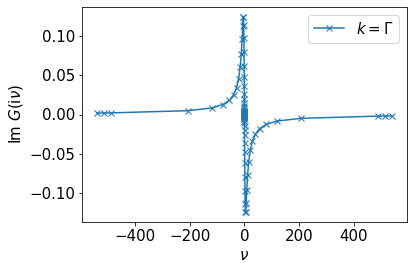

In [3]:
kps = (nk_lin, nk_lin)
nk = np.prod(kps)
nr = nk
kgrid = [2*np.pi*np.arange(kp)/kp for kp in kps]
k1, k2 = np.meshgrid(*kgrid, indexing="ij")
ek = -2*(np.cos(k1) + np.cos(k2))
print(k1.shape, k2.shape, ek.shape)

iv = 1j*np.pi*smpl_matsu.sampling_points/beta
gkf = 1.0 / (iv[:,None] - ek.ravel()[None,:])

plt.plot(smpl_matsu.sampling_points*np.pi/beta, gkf[:,0].imag, label=r"$k=\Gamma$", marker="x")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~G(\mathrm{i}\nu)$")
plt.legend()
plt.tight_layout()
plt.show()

### Step 3
Transform the Green's function to sampling times.

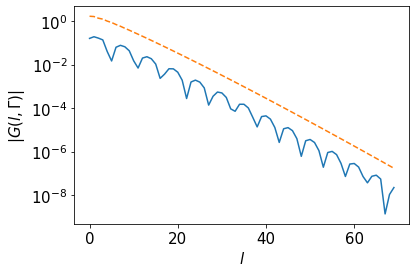

In [4]:
# G(l, k): (L, nk)
gkl = smpl_matsu.fit(gkf, axis=0)

assert gkl.shape == (L, nk)

plt.semilogy(np.abs(gkl[:,0]))
plt.semilogy(basis.s, ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|G(l, \Gamma)|$")
plt.show()

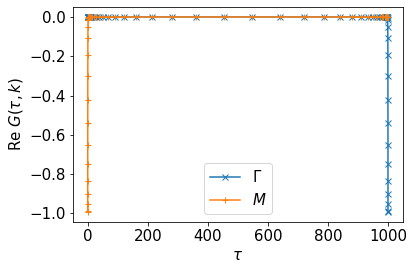

In [5]:
gkt = smpl_tau.evaluate(gkl)

assert gkt.shape == (ntau, nk)

plt.plot(smpl_tau.sampling_points, gkt[:,0].real, label=r'$\Gamma$', marker="x")
plt.plot(smpl_tau.sampling_points, 
    gkt.reshape(-1,*kps)[:,nk_lin//2,nk_lin//2].real, label=r'$M$', marker="+")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, k)$")
plt.legend()
plt.tight_layout()
plt.show()

### Step 4
Transform the Green's function to the real space and evaluate the self-energy

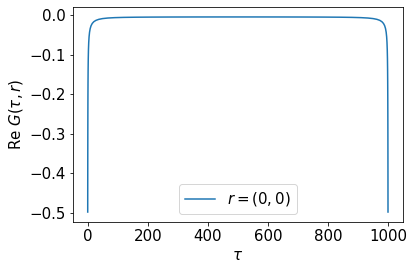

In [6]:
# Compute G(tau, r): (ntau, nk)
#  (1) Reshape gkt into shape of (ntau, nk_lin, nk_lin).
#  (2) Apply FFT to the axes 1, 2.
#  (3) Reshape the result to (ntau, nk)
# G(tau, k): (ntau, nk)
grt = fftn(gkt.reshape(ntau, *kps), axes=(1,2)).reshape(ntau, nk)/nk

plt.plot(smpl_tau.sampling_points, grt[:,0].real, label='$r=(0,0)$')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~G(\tau, r)$")
plt.legend()
plt.tight_layout()
plt.show()

Compute the second-order term of the self-energy on the sampling points

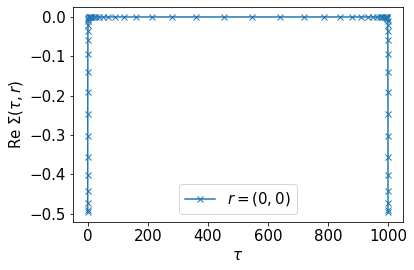

In [7]:
# Sigma(tau, r): (ntau, nr)
srt = U*U*grt*grt*grt[::-1,:]

plt.plot(smpl_tau.sampling_points, srt[:,0].real, label='$r=(0,0)$', marker="x")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mathrm{Re}~\Sigma(\tau, r)$")
plt.legend()
plt.tight_layout()
plt.show()

### Step 5
Tansform the self-energy to the IR basis and then transform it to the momentum spacre

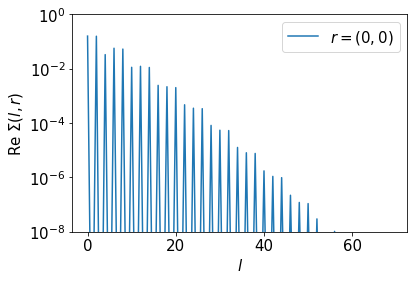

In [8]:
# Sigma(l, r): (L, nr)
srl = smpl_tau.fit(srt)
assert srl.shape == (L, nr)

plt.semilogy(np.abs(srl[:,0]), label='$r=(0,0)$')
plt.xlabel(r"$l$")
plt.ylabel(r"$\mathrm{Re}~\Sigma(l, r)$")
plt.ylim([1e-8,1])
plt.legend()
plt.show()

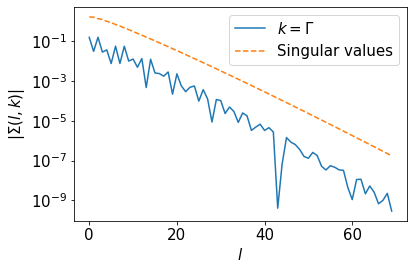

In [9]:
# Sigma(l, k): (L, nk)
srl = srl.reshape(L, *kps)
skl = ifftn(srl, axes=(1,2)) * nk
skl = skl.reshape(L, *kps)

#plt.semilogy(np.max(np.abs(skl),axis=(1,2)), label="max, abs")
plt.semilogy(np.abs(skl[:,0,0]), label="$k=\Gamma$")
plt.semilogy(basis.s, label="Singular values", ls="--")
plt.xlabel(r"$l$")
plt.ylabel(r"$|\Sigma(l, k)|$")
plt.legend()
plt.tight_layout()
plt.show()

### Step 6
Evaluate the self-energy on sampling frequencies

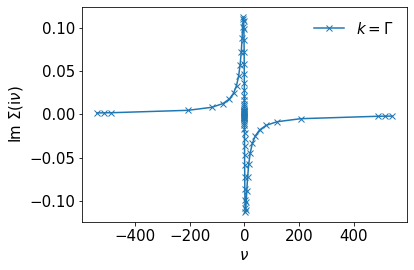

In [10]:
sigma_iv = smpl_matsu.evaluate(skl, axis=0)
plt.plot(smpl_matsu.sampling_points*np.pi/beta, sigma_iv[:,0,0].imag, marker='x', label=r"$k=\Gamma$")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~\Sigma(\mathrm{i}\nu)$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

You can evaluate the self-energy on arbitrary frequencies.

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/sparse_ir/sampling.py:34: ConditioningWarning: Sampling matrix is poorly conditioned (cond = 5.6e+14)
  warn("Sampling matrix is poorly conditioned (cond = %.2g)"


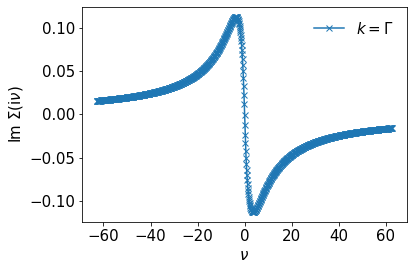

In [11]:
my_freqs = 2*np.arange(-10000, 10000, 20) + 1 # odd
smpl_matsu2 = sparse_ir.MatsubaraSampling(basis, my_freqs)
res = smpl_matsu2.evaluate(skl, axis=0)
plt.plot(my_freqs*np.pi/beta, res[:,0,0].imag, marker='x', label=r"$k=\Gamma$")
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\mathrm{Im}~\Sigma(\mathrm{i}\nu)$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()